In [1]:
from scipy import fftpack
from scipy import signal

In [2]:
import scipy.io.wavfile
from scipy import io

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

## Spectral analysis of simulated signal

In [4]:
def signal_samples(t):
    """ Simulated signal samples """
    return (2 * np.sin(2 * np.pi * t) +
            3 * np.sin(22 * 2 * np.pi * t) +
            2 * np.random.randn(*np.shape(t)))

In [7]:
np.random.seed(0)

In [6]:
B = 30.0
f_s = 2 * B
delta_f = 0.01
N = int(f_s / delta_f)
N

6000

In [8]:
T = N / f_s
T

100.0

In [9]:
t = np.linspace(0, T, N)
f_t = signal_samples(t)

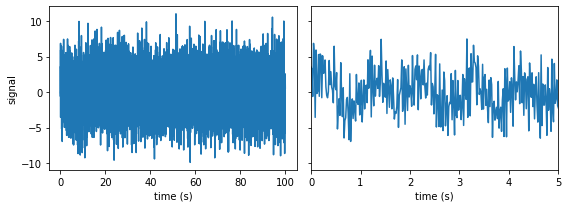

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")
fig.tight_layout()

In [11]:
F = fftpack.fft(f_t)
f = fftpack.fftfreq(N, 1/f_s)
mask = np.where(f >= 0)

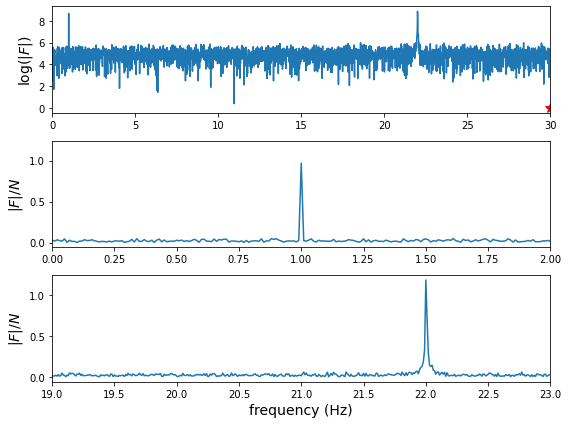

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_xlim(0, 30)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(f[mask], abs(F[mask])/N, label="real")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|/N$", fontsize=14)

axes[2].plot(f[mask], abs(F[mask])/N, label="real")
axes[2].set_xlim(19, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$|F|/N$", fontsize=14)

fig.tight_layout()

## Simple example of filtering

In [14]:
F_filtered = F * (abs(f) < 2)
f_t_filtered = fftpack.ifft(F_filtered)

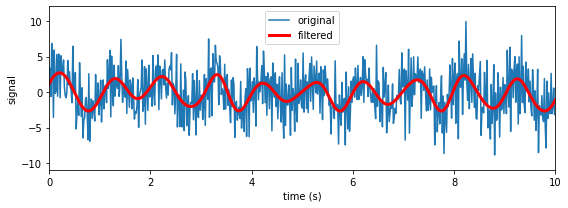

In [15]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label='original')
ax.plot(t, f_t_filtered.real, color="red", lw=3, label='filtered')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend()
fig.tight_layout()

## Windowing

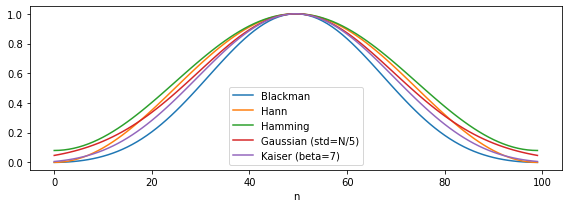

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N), label="Blackman")
ax.plot(signal.hann(N), label="Hann")
ax.plot(signal.hamming(N), label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5)")
ax.plot(signal.kaiser(N, 7), label="Kaiser (beta=7)")
ax.set_xlabel("n")
ax.legend(loc=0)
fig.tight_layout()

In [17]:
df = pd.read_csv('temperature_outdoor_2014.tsv', delimiter="\t", names=["time", "temperature"])
df.time = pd.to_datetime(df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm')
df = df.set_index("time")
df = df.resample("1H").ffill()
df = df[(df.index >= "2014-04-01")*(df.index < "2014-06-01")].dropna()

In [18]:
time = df.index.astype('int')/1e9
temperature = df.temperature.values

In [19]:
window = signal.blackman(len(temperature))

In [20]:
temperature_windowed = temperature * window

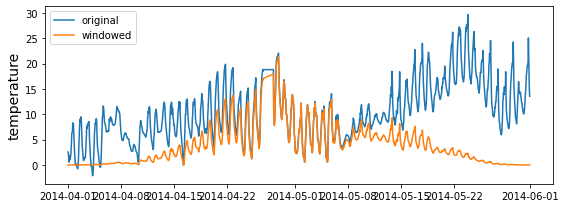

In [21]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original")
#ax.plot(df.index, temperature_detrended, label="detrended")
ax.plot(df.index, temperature_windowed, label="windowed")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()

In [26]:
data_fft_windowed = fftpack.fft(temperature_windowed)
f = fftpack.fftfreq(len(temperature_windowed), time[1]-time[0])

In [27]:
mask = f > 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


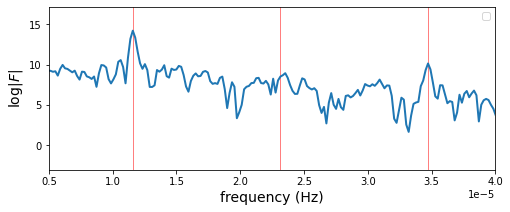

In [28]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)
ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])**2), lw=2)
#ax.plot(f[mask], np.log(abs(data_fft_detrended[mask])**2), lw=2, label="detrended")
#ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])**2), lw=2, label="windowed")
ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)

## Spectrogram of Guitar sound

In [30]:
# https://www.freesound.org/people/guitarguy1985/sounds/52047/

In [29]:
sample_rate, data = io.wavfile.read("guitar.wav")

In [31]:
sample_rate

44100

In [32]:
data.shape

(1181625, 2)

In [33]:
data = data.mean(axis=1)

In [34]:
data.shape[0] / sample_rate

26.79421768707483

In [36]:
N = int(sample_rate/2.0) # half a second

In [37]:
f = fftpack.fftfreq(N, 1.0/sample_rate)
t = np.linspace(0, 0.5, N)
mask = (f > 0) * (f < 1000)

In [38]:
subdata = data[:N]

In [39]:
F = fftpack.fft(subdata)

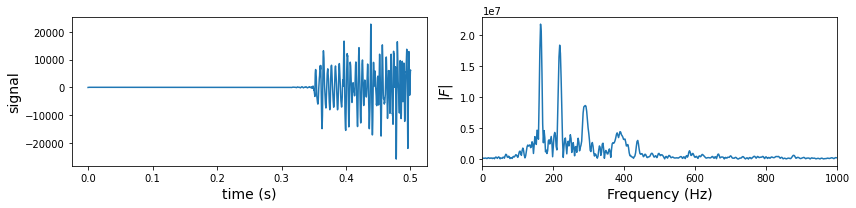

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()

In [41]:
N_max = int(data.shape[0] / N)
f_values = np.sum(1 * mask)
spect_data = np.zeros((N_max, f_values))

In [42]:
window = signal.blackman(len(subdata))

In [43]:
for n in range(0, N_max):
    subdata = data[(N * n):(N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spect_data[n, :] = np.log(abs(F[mask]))

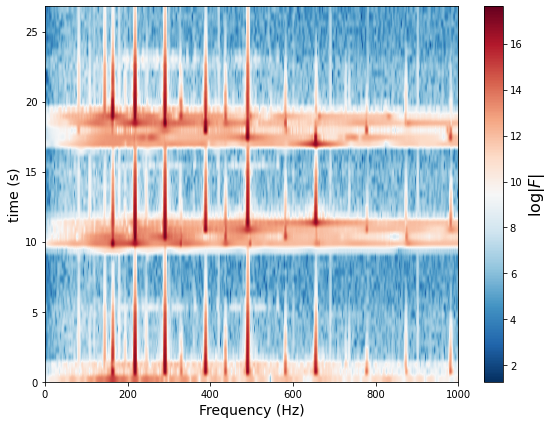

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(spect_data, origin='lower',
              extent=(0, 1000, 0, data.shape[0] / sample_rate),
              aspect='auto',
              cmap=mpl.cm.RdBu_r)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()

## Signal filters

### Convolution filters

In [45]:
t = np.linspace(0, T, N)
f_t = signal_samples(t)
H = (abs(f) < 2)
h = fftpack.fftshift(fftpack.ifft(H))
f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

ValueError: x and y must have same first dimension, but have shapes (22050,) and (6000,)

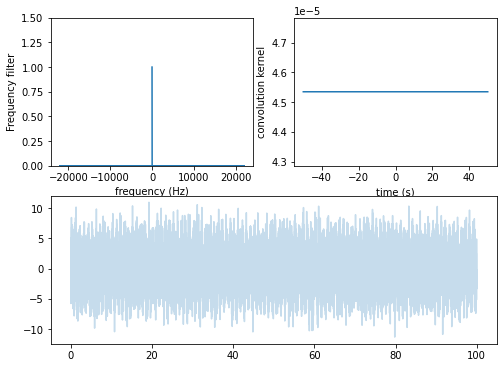

In [47]:
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - t[-1]/2.0, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real, "r", lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)


### FIR filter

In [48]:
n = 101
f_s = 1.0 / 3600
nyq = f_s/2
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

In [50]:
f, h = signal.freqz(b)

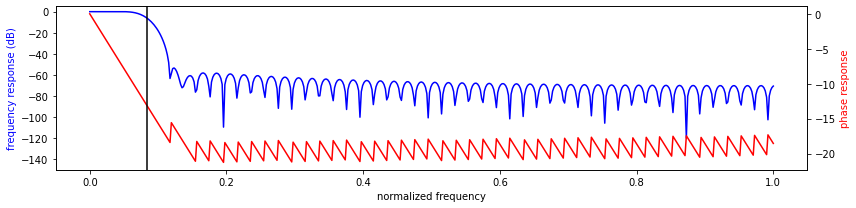

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase response', color="r")
ax.axvline(1.0/12, color="black")
fig.tight_layout()

In [52]:
temperature_filtered = signal.lfilter(b, 1, temperature)

In [53]:
temperature_median_filtered = signal.medfilt(temperature, 25)

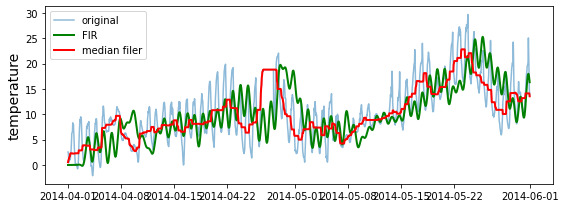

In [54]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered, color="green", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filtered, color="red", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()

### IIR filter

In [55]:
b, a = signal.butter(2, 7/365.0, btype='high')

In [56]:
b

array([ 0.95829139, -1.91658277,  0.95829139])

In [57]:
a

array([ 1.        , -1.91484241,  0.91832314])

In [58]:
temperature_filtered_iir = signal.lfilter(b, a, temperature)

In [59]:
temperature_filtered_filtfilt = signal.filtfilt(b, a, temperature)

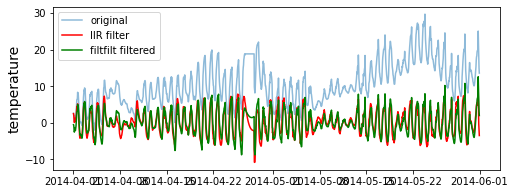

In [61]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered_iir, color="red", label="IIR filter")
ax.plot(df.index, temperature_filtered_filtfilt, color="green", label="filtfilt filtered")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)